# **Environment: Water Level Control of a Tank**

In [18]:
# Building the custom environment for OpenAi Gym

from gym import Env 
# Env is a placeholder class that allows us to build our environment

from gym.spaces import Box
# Superclass that is used to define observation and action spaces
#`Box` is for continuing-space, `Discrete` for discrete-space and `Dict` for multiple input
# https://github.com/openai/gym/blob/master/gym/spaces/box.py
"""Implementation of a space that represents closed boxes in euclidean space."""
"""
class Box(Space[np.ndarray]):
    A (possibly unbounded) box in :math:`\mathbb{R}^n`.
    Specifically, a Box represents the Cartesian product of n closed intervals.
    Each interval has the form of one of :math:`[a, b]`, :math:`(-\infty, b]`,
    :math:`[a, \infty)`, or :math:`(-\infty, \infty)`.
    There are two common use cases:
    * Identical bound for each dimension::
        >>> Box(low=-1.0, high=2.0, shape=(3, 4), dtype=np.float32)
        Box(3, 4)
    * Independent bound for each dimension::
        >>> Box(low=np.array([-1.0, -2.0]), high=np.array([2.0, 4.0]), dtype=np.float32)
        Box(2,)
    
"""
import numpy as np
import random

# (This removes np.float32 warnings, but can be solved with np.float64 at "box" definition):
# gym.logger.set_level(40) 

class Model(Env):
# By passing Env to the class Model we defined, we inherit the methods and properties of OpenAI Gym

    def __init__(self):

        # Actions we can take, we only have the valve opening at each timestep (we consider a lower/upper bound of |0.01|)
        self.action_space = Box(low=np.array([-0.01]), high=np.array([0.01]), dtype=np.float64)
        # The function "Box" can support a tensor

        # # Valve opening observation array (maximum physically possible opening of 1.0)
        # self.valve_opening  = Box(low=np.array([0.00]), high=np.array([1.00]), dtype=np.float64)

        # # Water Height observation array (assuming Maximum Height of Tank of 1.0 m)
        # self.water_height = Box(low=np.array([0.00]), high=np.array([1.00]), dtype=np.float64)

        # Inflow observation array (assuming Maximum Possible Flow of 150 m³/h) / remember: Inflow is not a state!
        # self.inflow = Box(low=np.array([0.00]), high=np.array([150.00]), dtype=np.float64)

        # Observation space array (only Valve opening and Water Height; both with lower bound 0.0 and upper bound 1.0)
        self.observation_space = Box(low=0, high=1.00, shape=(1, 2), dtype=np.float64)

        # Set observation space (reminder: flow isn't measured/ isn't a state)
        # self.observation_space = (self.inflow , self.valve_opening, self.water_height)

        ## Area of 3 m²
        ## Diameter of 1.95441 m
        self.tank_diameter = 1.95441

        # Set initial states (we can instantiate them a bit randomly - 10% var):
        # self.current_inflow = 100 + random.uniform(-10.00, 10.00)
        # self.current_valve_opening = 0.5 + random.uniform(-0.05, 0.05)
        # self.current_water_height = 0.5 + random.uniform(-0.05, 0.05)

        self.current_inflow = 100
        self.current_valve_opening = 0.5
        self.current_water_height = 0.5

        ##  Calculate Volume of Water inside Tank
        ##  Maximum Possible Volume of 3.0 m³
        self.current_water_volume = (((self.tank_diameter / 2) ** 2) * np.pi) * self.current_water_height

        ## Valve coefficient (Cv) is given
        self.valve_coefficient = 282.84

        ## Setpoint in terms of the Usual Operation Height of 0.5 m 
        self.setpoint =  0.5

        # Tolerance acceptable for setpoint error (in reward definition):
        self.tolerance = 1e-4 # test 1e-6
       
        self.state = (self.current_water_volume, self.current_inflow , self.current_valve_opening, self.current_water_height, self.setpoint, self.error())

        # Set episode length
        ## Timestep = 0.01h
        ## Episode total time = 2h (200 timesteps)
        ## Total number of episodes = 2000
        self.time_per_episode = 200

        # Initialize time counter
        self.time_step = 0

    ## Provides current water height from the most up to date water volume
    def update_water_height(self):
        return self.current_water_volume / (((self.tank_diameter / 2) ** 2) * np.pi)   
   
    ## Calculates the non-linear outflow rate of water from the tank
    def outflow(self):
        return self.valve_coefficient * self.current_valve_opening * np.sqrt(abs(self.update_water_height())) 

    ## Error of water height from current set point
    def error(self):
        error=(self.update_water_height() - self.setpoint)
        return error
        
    def step(self, action):

        # Flow rate of water + disturbances
        self.current_inflow = self.current_inflow + self.disturbance(self.time_step)

        ## Current water volume in the tank
        self.current_water_volume = self.current_water_volume + self.current_inflow - self.outflow()

        ## Update current water height
        self.current_water_height = self.update_water_height()

        # Apply action (valve opening)
        # Continuous: [-0.01, 0.01] at each timestep
        self.current_valve_opening += action

        # Add 1 Timestep = 0.01h
        self.time_step += 1
        
        # Calculate reward
        ## Reward: minus the square of height error -(m)^2
        ## Our objective is to minimize this error (or negative reward)
        # reward = -((self.error())**2)

        if (self.error())**2 <= self.tolerance : 
            reward = 1 
        else: 
            reward = -1 

        ## Determine whether it is a terminal state
        terminal = self.is_terminal(self.current_water_height)

        # Set placeholder for info
        info = {}

        # Return step information
        return self.retrieve_observation(), reward, terminal, info

    ## The terminal state is reached if time step reaches more than 200 or if water level is at 2 extremes
    def is_terminal(self, water_h):
        if self.time_step >= self.time_per_episode-1 or self.current_water_height == 0 or self.current_water_height == 1:
            return True
        else:
            return False

    ## Disturbances on flow rate:
    def disturbance(self, time):
        if self.time_step == 10: #0.1 h
            return 20
        elif self.time_step == 100: #1.1 h
            return -20
        else:
            return 0

    ## Retrieve current state
    def retrieve_observation(self):

        self.state = (
            self.current_water_volume, self.current_inflow , self.current_valve_opening, self.current_water_height, self.setpoint, self.error()
        )
        return self.state

    def render(self):
        # Implement visualization for a game environment for example
        pass
    
    ## Reset the current state of the water tank. This involves time_step, water volume, input flow rate of water and error
    def reset(self):

        ## Set point remains fixed:
        self.setpoint = 0.5

        ## Reset time counter and other variables (we can instantiate them as before, a bit randomly)
        self.time_step = 0
        # self.current_inflow = 100 + random.uniform(-10.00, 10.00)
        # self.current_valve_opening = 0.5 + random.uniform(-0.05, 0.05)
        # self.current_water_height = 0.5 + random.uniform(-0.05, 0.05)

        self.current_inflow = 100
        self.current_valve_opening = 0.5
        self.current_water_height = 0.5

        return self.retrieve_observation()

In [19]:
env = Model()

In [12]:
# Just to see if the bounds of observation space (H and Xv) are defined correctly

a = env.observation_space.low
print(a)

b = env.observation_space.high
print(b)

[[0. 0.]]
[[1. 1.]]


In [13]:
# getattr() – This function is used to access the attribute of object, like a class.

print (getattr(env,'time_step')) 
print (getattr(env,'current_inflow')) 
print (getattr(env,'current_valve_opening')) 
print (getattr(env,'current_water_height')) 
print (getattr(env,'setpoint')) 

0
100
0.5
0.5
0.5


In [14]:
#Python calling method (error) in class (model/'env')

env.error()

0.0

In [15]:
env.update_water_height()

0.5

In [16]:
env.outflow()

99.99904099540154

In [20]:
# Python calling method (step) in class (model/'env')
# Just to see 1 step, with an action of +0.01 on Xv (valve_opening)

env.step(0.01)

# Remember of the output we defined from retrieve.observation():
# self.current_water_volume, self.current_inflow , self.current_valve_opening, self.current_water_height, self.setpoint, self.error()

# And after we have also from the return of step(): 
# reward, terminal, info.

((1.500958931515001,
  100,
  0.51,
  0.5003196682150601,
  0.5,
  0.00031966821506013154),
 1,
 False,
 {})

In [21]:
env.outflow()

102.03162245069028

In [22]:
# Python calling method (step) in class (model/'env')
# Just to see 1 step, with an action of +0.01 on Xv (valve_opening)

env.step(0.01)

# Remember of the output we defined from retrieve.observation():
# self.current_water_volume, self.current_inflow , self.current_valve_opening, self.current_water_height, self.setpoint, self.error()

# And after we have also from the return of step(): 
# reward, terminal, info.

((-0.5306635191752775,
  100,
  0.52,
  -0.17688784834347585,
  0.5,
  -0.6768878483434758),
 -1,
 False,
 {})

In [23]:
env.outflow()

61.85761508728306

In [ ]:
# This allows us to see numpy arrays with more precision
# (print with a higher number of digits of precision for floating point output)

np.set_printoptions(precision=4) 

In [ ]:
# Just to confirm that the observation space (of valve_opening) is a continuum between [0, 1]

env.observation_space.sample()

array([[0.1423, 0.2294]])

In [17]:
# Just to confirm that the action space (of valve_opening) is a continuum between [-0.01, 0.01]

env.action_space.sample()

array([-0.00626735])

In [38]:
# Just to test the environment with random control actions
# The score is similar to return (sum of rewards)

episodes = 10
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        #env.render()
        action = env.action_space.sample() #take a random action from the action space
        n_state, reward, done, info = env.step(action)
        score+=reward
    print('Episode:{} Score:{}'.format(episode, score))

Episode:1 Score:-199
Episode:2 Score:-199
Episode:3 Score:-199
Episode:4 Score:-199
Episode:5 Score:-199
Episode:6 Score:-199
Episode:7 Score:-199
Episode:8 Score:-199
Episode:9 Score:-199
Episode:10 Score:-199


## **Sarsa ($\lambda$) with Gaussian RBF approximation**

In [ ]:
states = env.observation_space.shape
# actions = env.action_space.n  # this is for discrete action space
num_actions = env.action_space.shape

In [ ]:
num_actions
# We have a tuple on the number of possible actions (actually is just one continuous action space "valve_opening")

(1,)

In [ ]:
#We need to transform this tuple on an integer (int doesn't work here)
# Method 1: sum()
t = (1, 2, 3)
i = sum(t)
print(i)

6


In [ ]:
xbar

array([[0., 0.],
       [1., 1.]])

In [ ]:
# SARSA-lambda with Gaussian radial basis functions for action-value approximation
# Implemented for the OpenAI gym mountain-car environment

import gym
import numpy as np
import matplotlib.pyplot as plt

# Initializations
env = Model()
states = env.observation_space.shape
# actions = env.action_space.n  # this is for discrete action space
num_actions = env.action_space.shape
num_actions_int  = sum(num_actions)  # transforming tuple on integer
dim = env.observation_space.high.size

num_actions = 3

# Parameters
# eps = 0.1, Lambda = 0.5, alpha = 0.008, gamma = 0.99
num_rbf = 4 * np.ones(num_actions).astype(int)
width = 1. / (num_rbf - 1.)
rbf_sigma = width[0] / 2.
epsilon = 0.1
epsilon_final = 0.1
Lambda = 0.5
alpha = 0.01
gamma = 0.99
num_episodes = 2000
num_timesteps = 200

xbar = np.zeros((2, dim))
xbar[0, :] = env.observation_space.low
xbar[1, :] = env.observation_space.high
num_ind = np.prod(num_rbf)
activations = np.zeros(num_ind)
new_activations = np.zeros(num_ind)
theta = np.zeros((num_ind, num_actions))
rbf_den = 2 * rbf_sigma ** 2
epsilon_coefficient = (epsilon - epsilon_final) ** (1. / num_episodes)
ep_length = np.zeros(num_episodes)
np.set_printoptions(precision=2)


# Construct ndarray of rbf centers
c = np.zeros((num_ind, dim))
for i in range(num_rbf[0]):
    for j in range(num_rbf[1]):
        c[i*num_rbf[1] + j, :] = (i * width[1], j * width[0])


# Returns the state scaled between 0 and 1
# def normalize_state(_s):
#     _y = np.zeros(len(_s))
#     for _i in range(len(_s)):
#         _y[_i] = (_s[_i] - xbar[0, _i]) / (xbar[1, _i] - xbar[0, _i])
#     return _y


# Returns an ndarray of radial basis function activations
def phi(_state):
    _phi = np.zeros(num_ind)
    for _k in range(num_ind):
        _phi[_k] = np.exp(-np.linalg.norm(_state - c[_k, :]) ** 2 / rbf_den)
    return _phi


# Returns an action following an epsilon-greedy policy
def epsilon_greedy(_epsilon, _vals):
    _rand = np.random.random()
    if _rand < 1. - _epsilon:
        _action = _vals.argmax()
    else:
        _action = env.action_space.sample()
    return int(_action)


# Returns the value of each action at some state
def action_values(_activations, _theta):
    _val = np.dot(_theta.T, _activations)
    return _val


# Returns the value of an action at some state
def action_value(_activations, _action, _theta):
    _val = np.dot(_theta[:, _action], _activations)
    return _val


# SARSA loop
for ep in range(num_episodes):

    e = np.zeros((num_ind, num_actions))
    state = env.reset()
    activations = phi(state)
    # print "activations = ", np.reshape(activations.ravel(order='F'), (num_rows, num_cols))
    vals = action_values(activations, theta)
    action = epsilon_greedy(epsilon, vals)

    # Each episode
    for t in range(num_timesteps):

        # env.render()
        new_state, reward, done, info = env.step(action)
        # new_state = normalize_state(new_state)
        new_activations = phi(new_state)
        new_vals = action_values(new_activations, theta)
        new_action = epsilon_greedy(epsilon, new_vals)
        Q = action_value(activations, action, theta)
        Q_new = action_value(new_activations, new_action, theta)
        if done:
            target = reward - Q
        else:
            target = reward + gamma * Q_new - Q
        # e[:, action] += activations  # accumulating traces
        e[:, action] = activations  # replacing traces

        for k in range(num_ind):
            for a in range(num_actions):
                theta[k, a] += alpha * target * e[k, a]
        e *= gamma * Lambda

        if t % 1 != 0:
            # print "t = ", t
            # print "new_state = ", new_state
            # print "new_activations = ", np.reshape(new_activations.ravel(order='F'), (num_rows, num_cols))
            # print "new_vals", new_vals
            # print "Q = ", Q
            # print "Q_new = ", Q_new
            # print "action = ", action
            # print "target = ", target
            # print "e =", e
            # print "theta = \n", np.reshape(theta.ravel(order='F'), (num_actions, num_rows, num_cols))
            # print "---------------------------------------------------------------------------"

          state = new_state.copy()
          activations = new_activations.copy()
          action = new_action
        if done:
            break

    ep_length[ep] = t
    # print "t = ", t
    epsilon *= epsilon_coefficient


value_left = np.zeros(num_ind)
value_nothing = np.zeros(num_ind)
value_right = np.zeros(num_ind)

# Display each action-value as a heatmap
for h in range(num_ind):
    current_activations = phi(c[h, :])
    value_left[h] += action_value(current_activations, 0, theta)
    value_nothing[h] += action_value(current_activations, 1, theta)
    value_right[h] += action_value(current_activations, 2, theta)

plt.close('all')
fig, axes = plt.subplots(ncols=3, sharey=True)
plt.setp(axes.flat, aspect=1.0, adjustable='box')
im = axes[0].imshow(value_left.reshape((8, 8)), cmap='hot')
axes[0].set_title('Action = left')
axes[0].set_ylabel('Position')
axes[0].set_xlabel('Velocity')
im = axes[1].imshow(value_nothing.reshape((8, 8)), cmap='hot')
axes[1].set_title('Action = nothing')
im = axes[2].imshow(value_right.reshape((8, 8)), cmap='hot')
axes[2].set_title('Action = right')
# fig.subplots_adjust(bottom=0.2)
# cbar_ax = fig.add_axes([0.15, 0.15, 0.7, 0.05])
# cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
# plt.axis([0, 1, 0, 1])

plt.figure(2)
plt.plot(ep_length)
plt.title('Episode Length')
plt.ylabel('Completion Time')
plt.xlabel('Episode')
plt.show()

ValueError: ignored

Text(0.5, 1.0, 'Action = right')

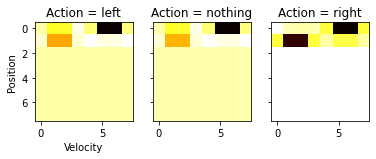

In [ ]:
fig, axes = plt.subplots(ncols=3, sharey=True)
plt.setp(axes.flat, aspect=1.0, adjustable='box')
im = axes[0].imshow(value_left.reshape((8, 8)), cmap='hot')
axes[0].set_title('Action = left')
axes[0].set_ylabel('Position')
axes[0].set_xlabel('Velocity')
im = axes[1].imshow(value_nothing.reshape((8, 8)), cmap='hot')
axes[1].set_title('Action = nothing')
im = axes[2].imshow(value_right.reshape((8, 8)), cmap='hot')
axes[2].set_title('Action = right')

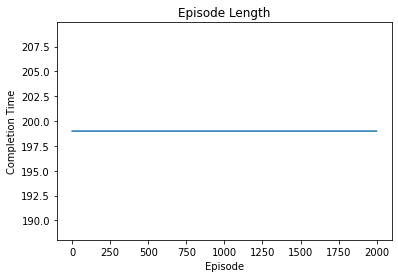

In [ ]:
plt.figure(2)
plt.plot(ep_length)
plt.title('Episode Length')
plt.ylabel('Completion Time')
plt.xlabel('Episode')
plt.show()